     index evaluation     score    type
0        0         32  1.810245  normal
1        1         64  2.960265  normal
2        2         96  3.696758  normal
3        3        128  3.696758  normal
4        4        160  3.788749  normal
..     ...        ...       ...     ...
379     27      616.0  6.166677    fast
380     28      638.0  6.346300    fast
381     29      660.0  8.577279    fast
382     30      682.0  8.577279    fast
383     31      704.0  8.577279    fast

[384 rows x 4 columns]


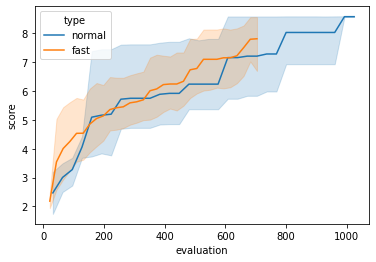

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns

root_dir = os.path.dirname(Path().resolve())
root_dir=os.path.join(root_dir, 'examples')
seed=10
expr_name='Jumper-v0_PlatformJumper-v0'
expr_name_normal='UpStepper-v0_TournamentGA'
expr_name_fast='UpStepper-v0_TournamentFastGA'



generation=31


def max_fit_list(save_dir,generation,is_multi=False):
    fitness_gen=[]
    evaluation_list=[]
    for i in range(generation+1):
        log_dir = os.path.join(save_dir,'generation_'+str(i),'output.txt')
        with open(log_dir) as f:
            fitnesses=[]
            for line in f:
                try:
                    if is_multi:
                        fitnesses.append(float(line.split()[2]))
                    else:
                        fitnesses.append(float(line.split()[1]))
                except:
                    evaluation_list.append(int(line.split()[2]))
            if is_multi:
                evaluation_list.append(fitnesses[len(fitnesses)-1])
                del fitnesses[len(fitnesses)-1]
            fitness_gen.append(max(fitnesses))
    return fitness_gen,evaluation_list

def average_graph(expr_name,seed_list,generation,is_multi):
    mat=np.empty([0,generation+1])
    for seed in seed_list:
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        np_arr=np.array(fitness_list)[np.newaxis,:]
        mat=np.concatenate([mat,np_arr])
    data=np.average(mat,axis=0)
    return data,evaluation_list

def data_for_confidence(expr_name,seed_list,generation,is_multi,is_fast):
    df=pd.DataFrame(columns=['evaluation','score'])
    for seed in seed_list:
        sub_df = pd.DataFrame(columns=['evaluation','score'])
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        sub_df['evaluation'] = np.array([evaluation_list[i]*11/16.0 for i in range(generation+1)]) if is_fast else evaluation_list
        sub_df['score'] = fitness_list
        df = pd.concat([df,sub_df],axis=0)
    elem='fast' if is_fast else 'normal'
    df['type']=np.array([elem for i in range(len(df))])
    return df

# def data_for_confidence_multi(...):
# data_for_confidence()
# list
# data['hue'] = list

def plot_confidence(df):
    
    df=df.reset_index()
    print(df)
    sns.lineplot(x="evaluation", y="score", data=df,hue='type')
    plt.xlabel('evaluation')
    plt.savefig('evaluation_score.pdf')

def plot_graph(data,eval_list,label,is_eval_base=True):
    fig = plt.figure(figsize=(12, 8)) #...1
    
    # Figure内にAxesを追加()
    ax = fig.add_subplot(111) #...2
    if is_eval_base==False:
        eval_list[1]=np.array(eval_list[1])/2
    ax.plot(eval_list[1], data[1], label=label[1]) #...3
    ax.plot(eval_list[0], data[0], label=label[0]) #...3
    plt.xlabel('evaluations' if is_eval_base else 'evaluated design')
    plt.ylabel('score of platformjumper')
    plt.ylim([1.7,2.8])

    # 凡例の表示
    plt.legend()

    # プロット表示(設定の反映)
    plt.show()
    

data_normal,eval_list_normal=average_graph(expr_name_normal,[0,1,6,9],31,False)
data_fast,eval_list_fast=average_graph(expr_name_fast,[6,7,8,9,11,12,13,14],31,False)
df_normal=data_for_confidence(expr_name_normal,[0,1,6,9],31,False,False)
df_fast=data_for_confidence(expr_name_fast,[6,7,8,9,11,12,13,14],31,False,True)
#df_normal.head(5)
plot_confidence(pd.concat([df_normal,df_fast]))
#plot_graph([data_single,data_multi],[eval_list_single,eval_list_multi],['GA:4 seed average','multi:5 seed average'])

In [9]:
import numpy as np
arr=np.zeros((2,10))
print(np.ravel(arr))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
